In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D, Conv1D, Concatenate, Activation)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

maxval = 1e9
minval = 1e-9
pi = 3.14159265359

2023-02-14 19:59:15.007453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 19:59:15.247670: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-14 19:59:15.260020: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 19:59:15.260060: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
datadir='/uscms/home/jennetd/nobackup/smart-pixels/directional-pixel-detectors/hit-position/'
train_df = pd.read_csv(datadir+'train_2D.csv',nrows=1000000)
test_df = pd.read_csv(datadir+'test_2D.csv',nrows=250000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','y-midplane','cotAlpha','cotBeta','pt'],).values
X_test = test_df.drop(columns=['x-midplane','y-midplane','cotAlpha','cotBeta','pt']).values

y_train = train_df[['x-midplane','y-midplane']].values
y_test = test_df[['x-midplane','y-midplane']].values

del train_df

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
def custom_loss(y, p):
    
    mu = tf.gather(params=p, indices=[0,1], axis=1)

    M11 = minval + tf.squeeze(tf.math.softplus(tf.gather(params=p, indices=[2], axis=1)),[1])
    M21 = minval + tf.squeeze(tf.math.softplus(tf.gather(params=p, indices=[3], axis=1)),[1])
    M22 = minval + tf.squeeze(tf.math.softplus(tf.gather(params=p, indices=[4], axis=1)),[1])
    
    row1 = tf.stack([M11,0*M11])
    row2 = tf.stack([M21,M22])
    
    scale_tril = tf.transpose(tf.stack([row1,row2]))
    
    dist = tfp.distributions.MultivariateNormalTriL(loc = mu, scale_tril = scale_tril)
      
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL)

In [7]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(5, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 273)]             0         
                                                                 
 dense1 (Dense)              (None, 64)                17536     
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 dense2 (Dense)              (None, 5)                 325       
                                                                 
Total params: 17,861
Trainable params: 17,861
Non-trainable params: 0
_________________________________________________________________


2023-02-14 20:00:38.376583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-14 20:00:38.376694: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-14 20:00:38.376779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2023-02-14 20:00:38.377601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=1000, 
                    batch_size=2048,
                    validation_split=0.1,
                    shuffle=True,
                    verbose=1)

Epoch 1/1000
440/440 [==============================] - 9s 14ms/step - loss: 30522.1973 - val_loss: 19598.6211
Epoch 2/1000
440/440 [==============================] - 6s 13ms/step - loss: 18787.7305 - val_loss: 18076.7148
Epoch 3/1000
440/440 [==============================] - 6s 13ms/step - loss: 17350.7090 - val_loss: 16850.4492
Epoch 4/1000
440/440 [==============================] - 6s 14ms/step - loss: 16709.1543 - val_loss: 16463.0840
Epoch 5/1000
440/440 [==============================] - 6s 13ms/step - loss: 16343.1836 - val_loss: 16123.7686
Epoch 6/1000
440/440 [==============================] - 5s 12ms/step - loss: 16012.9619 - val_loss: 15797.5400
Epoch 7/1000
440/440 [==============================] - 6s 13ms/step - loss: 15664.1602 - val_loss: 15426.2441
Epoch 8/1000
440/440 [==============================] - 6s 13ms/step - loss: 15269.5107 - val_loss: 15012.2178
Epoch 9/1000
440/440 [==============================] - 6s 14ms/step - loss: 14833.6367 - val_loss: 14559.6709
E

/tmp/ipykernel_148737/4052347745.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


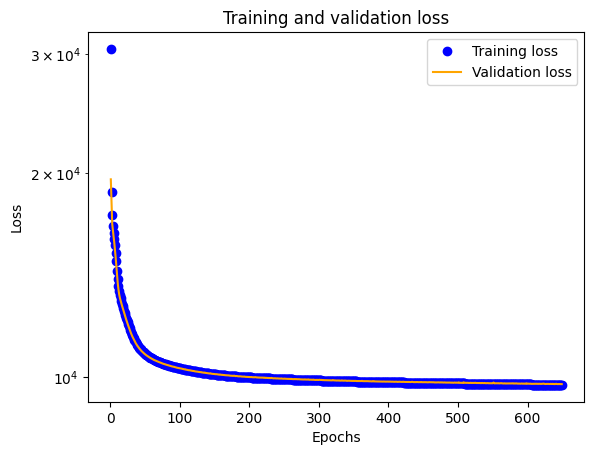

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()

In [10]:
model.save('models_2Dxy/multinorm.keras')

In [12]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mux','muy','M11','M21','M22'])
df['M11'] = minval + tf.math.softplus(df['M11'])
df['M21'] = minval + tf.math.softplus(df['M21'])
df['M22'] = minval + tf.math.softplus(df['M22'])
df['xtrue'] = test_df['x-midplane']
df['ytrue'] = test_df['y-midplane']

del test_df

df['sigmax'] = df['M11']
df['sigmay'] = np.sqrt(df['M21']*df['M21'] + df['M22']*df['M22'])
df['cov'] = np.sqrt(df['M11']*df['M21'])

df.to_csv("test_2DxyMultiNorm.csv",header=False,index=False)

7813/7813 [==============================] - 13s 2ms/step


0.043138271618512386 7.629196356152105


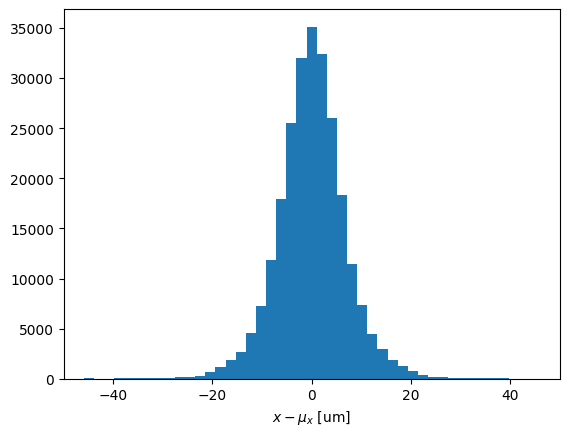

In [13]:
xresiduals = df['xtrue']-df['mux']
print(np.mean(xresiduals),np.std(xresiduals))

plt.hist(xresiduals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.xlim(-50,50)
plt.show()

7.0180736 3.1941977


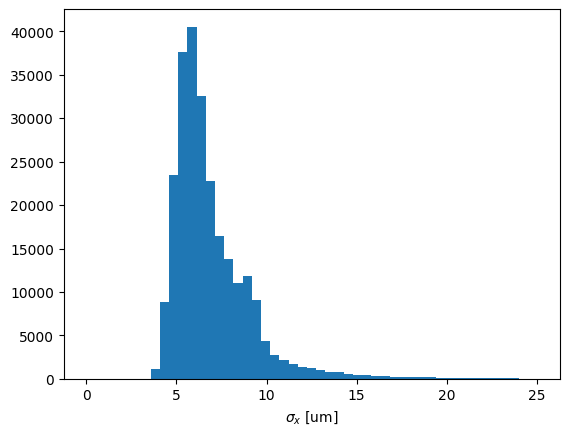

In [14]:
print(np.mean(df['sigmax']),np.std(df['sigmax']))

plt.hist(df['sigmax'],bins=np.linspace(0,25,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

-0.023154200934745194 1.8630934847660992


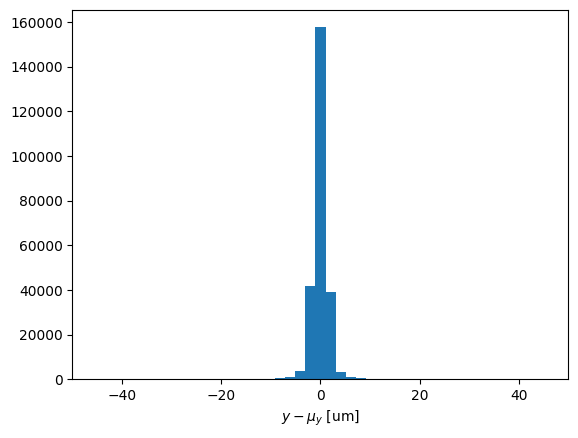

In [15]:
yresiduals = df['ytrue']-df['muy']
print(np.mean(yresiduals),np.std(yresiduals))

plt.hist(yresiduals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')
plt.xlim(-50,50)
plt.show()

1.8552353 1.2073046


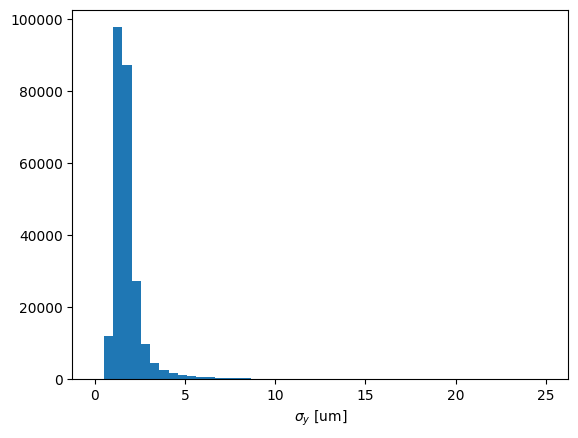

In [16]:
print(np.mean(df['sigmay']),np.std(df['sigmay']))

plt.hist(df['sigmay'],bins=np.linspace(0,25,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_y$ [um]')
plt.show()

/tmp/ipykernel_148737/2618733405.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


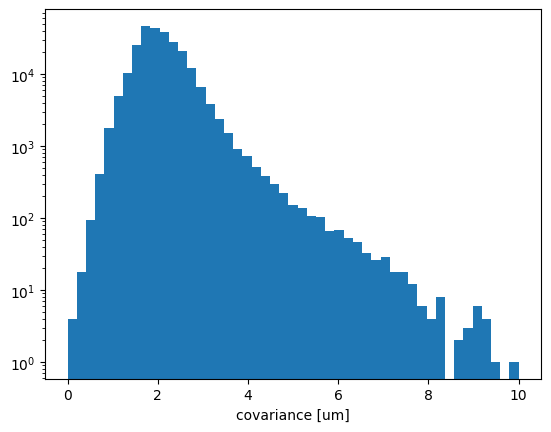

In [17]:
plt.hist(df['cov'],bins=np.linspace(0,10,50));
plt.yscale('Log')
plt.xlabel(r'covariance [um]')
plt.show()

In [18]:
df_1dx = pd.read_csv('test_1DxGauss.csv',header=None,names=['mu','sigma','xtrue'])
df_1dx.head()

,mu,sigma,xtrue
0,29.969585,5.203071,35.970951
1,-0.287672,4.929564,0.770363
2,-30.719051,6.458121,-37.471662
3,-19.176640,5.216318,-10.147963
4,-70.969380,4.316263,-73.204875


In [19]:
df_1dy = pd.read_csv('test_1DyGauss.csv',header=None,names=['mu','sigma','ytrue'])
df_1dy.head()

,mu,sigma,ytrue
0,-4.375186,1.348217,-4.155753
1,4.925593,0.989651,5.268802
2,0.201971,1.382961,-1.388992
3,16.869495,3.078876,4.737947
4,-2.397107,1.233690,-4.446499


In [20]:
df_2dx = pd.read_csv('test_2DxGauss.csv',header=None,names=['mu','sigma','xtrue'])
df_2dx.head()

,mu,sigma,xtrue
0,-53.309870,10.522069,-46.684825
1,54.203410,6.356477,63.321594
2,-49.594013,1.243751,-54.243993
3,24.108675,6.680157,26.554883
4,53.475647,1.751877,58.023551


In [21]:
df_2dy = pd.read_csv('test_2DyGauss.csv',header=None,names=['mu','sigma','ytrue'])
df_2dy.head()

,mu,sigma,ytrue
0,-5.477398,0.297887,-5.269646
1,12.681811,0.473679,12.832723
2,17.471151,1.509480,16.483230
3,-10.521870,1.240087,-9.731144
4,5.806390,0.561408,5.776402


Text(0.5, 0, '$x-\\mu_x$ [um]')

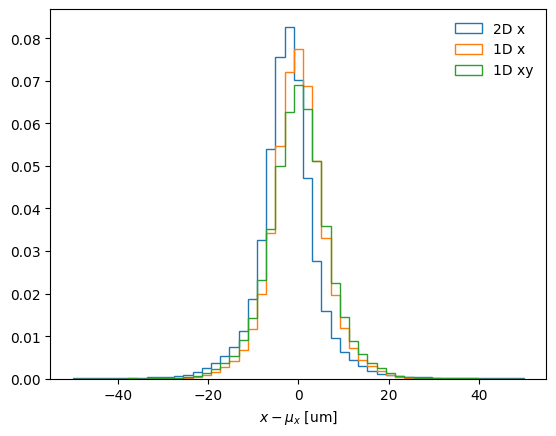

In [22]:
plt.hist(df_2dx['xtrue'] - df_2dx['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'2D x',density=True);
plt.hist(df_1dx['xtrue'] - df_1dx['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'1D x',density=True);
plt.hist(df['xtrue'] - df['mux'],histtype='step',bins=np.linspace(-50,50,50),label=r'1D xy',density=True);
plt.legend(frameon=False)
plt.xlabel(r'$x-\mu_x$ [um]')

Text(0.5, 0, '$\\sigma_x$ [um]')

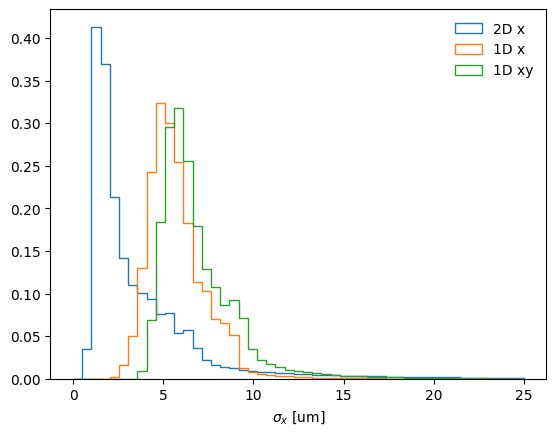

In [23]:
plt.hist(df_2dx['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'2D x',density=True);
plt.hist(df_1dx['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D x',density=True);
plt.hist(df['sigmax'],histtype='step',bins=np.linspace(0,25,50),label=r'1D xy',density=True);
plt.legend(frameon=False)
plt.xlabel(r'$\sigma_x$ [um]')

Text(0.5, 0, '$y-\\mu_y$ [um]')

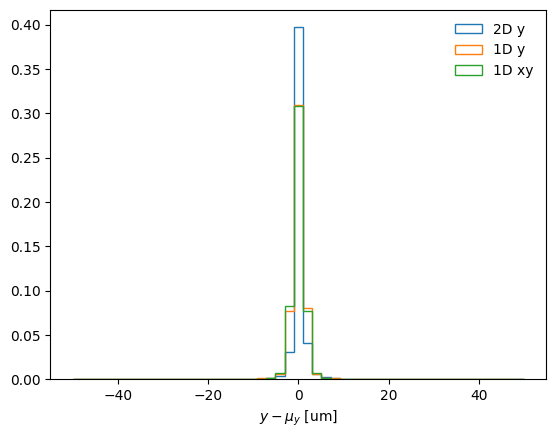

In [24]:
plt.hist(df_2dy['ytrue'] - df_2dy['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'2D y',density=True);
plt.hist(df_1dy['ytrue'] - df_1dy['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'1D y',density=True);
plt.hist(df['ytrue'] - df['muy'],histtype='step',bins=np.linspace(-50,50,50),label=r'1D xy',density=True);
plt.legend(frameon=False)
plt.xlabel(r'$y-\mu_y$ [um]')

Text(0.5, 0, '$\\sigma_y$ [um]')

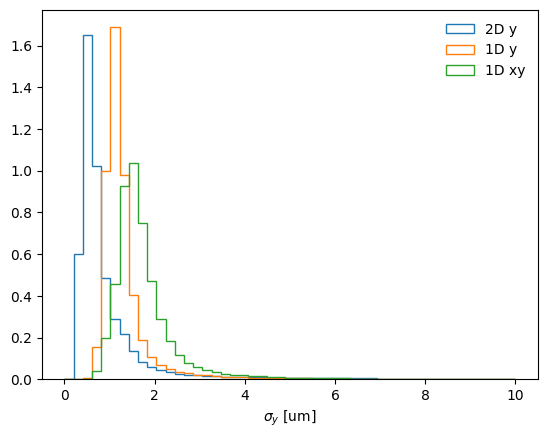

In [25]:
plt.hist(df_2dy['sigma'],histtype='step',bins=np.linspace(0,10,50),label=r'2D y',density=True);
plt.hist(df_1dy['sigma'],histtype='step',bins=np.linspace(0,10,50),label=r'1D y',density=True);
plt.hist(df['sigmay'],histtype='step',bins=np.linspace(0,10,50),label=r'1D xy',density=True);
plt.legend(frameon=False)
plt.xlabel(r'$\sigma_y$ [um]')

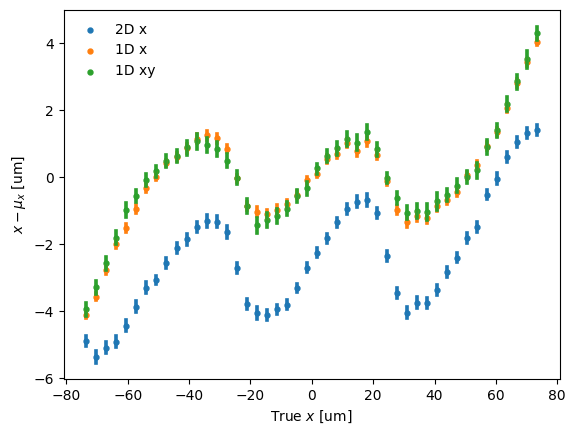

In [26]:
x = sns.regplot(x=df_2dx['xtrue'], y=df_2dx['xtrue']-df_2dx['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='2D x')
x = sns.regplot(x=df_1dx['xtrue'], y=df_1dx['xtrue']-df_1dx['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D x')
x = sns.regplot(x=df['xtrue'], y=df['xtrue']-df['mux'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D xy')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')
plt.legend(frameon=False)

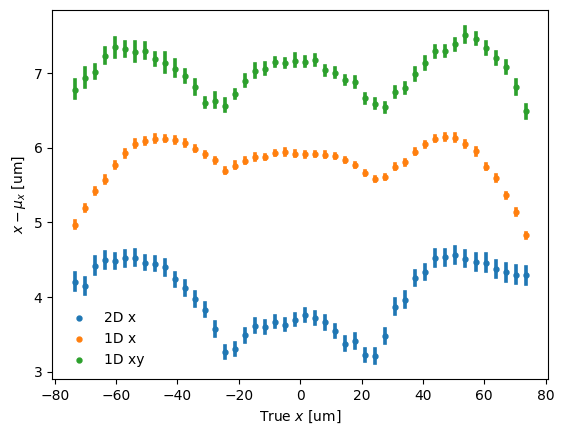

In [27]:
x = sns.regplot(x=df_2dx['xtrue'], y=df_2dx['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='2D x')
x = sns.regplot(x=df_1dx['xtrue'], y=df_1dx['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D x')
x = sns.regplot(x=df['xtrue'], y=df['sigmax'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D xy')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$\sigma$ [um]')
plt.legend(frameon=False)

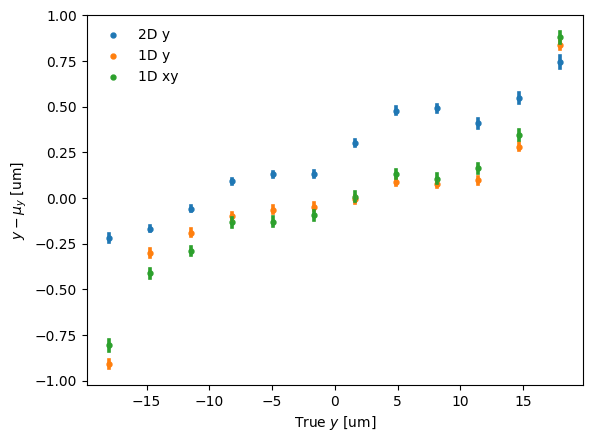

In [28]:
x = sns.regplot(x=df_2dy['ytrue'], y=df_2dy['ytrue']-df_2dy['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='2D y')
x = sns.regplot(x=df_1dy['ytrue'], y=df_1dy['ytrue']-df_1dy['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D y')
x = sns.regplot(x=df['ytrue'], y=df['ytrue']-df['muy'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D xy')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')
plt.legend(frameon=False)

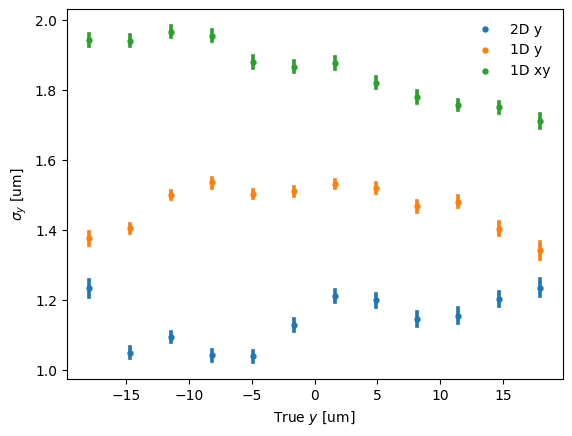

In [32]:
x = sns.regplot(x=df_2dy['ytrue'], y=df_2dy['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='2D y')
x = sns.regplot(x=df_1dy['ytrue'], y=df_1dy['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D y')
x = sns.regplot(x=df['ytrue'], y=df['sigmay'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D xy')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$\sigma_y$ [um]')
plt.legend(frameon=False)

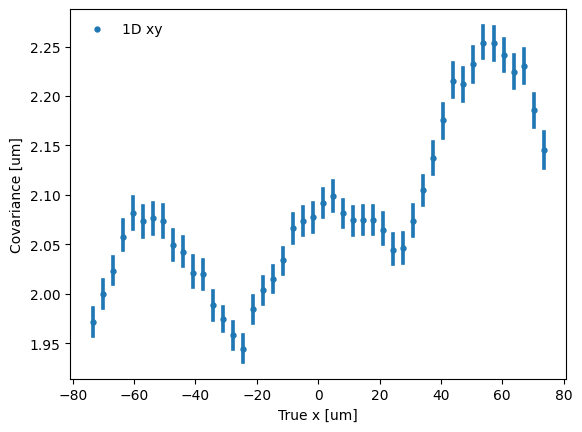

In [42]:
x = sns.regplot(x=df['xtrue'], y=df['cov'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='1D xy')
plt.xlabel(r'True x [um]')
plt.ylabel(r'Covariance [um]')
plt.legend(frameon=False)

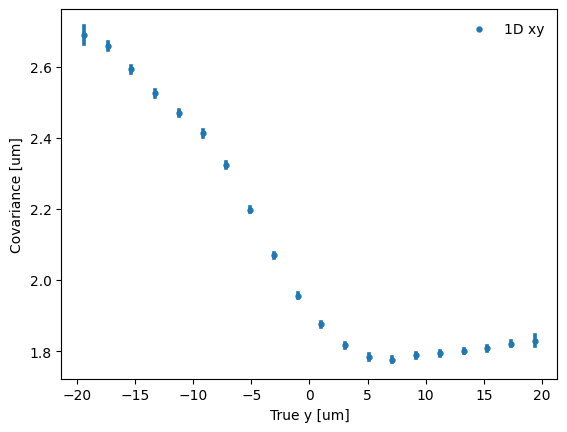

In [44]:
x = sns.regplot(x=df['ytrue'], y=df['cov'], x_bins=np.linspace(-50,50,50), fit_reg=None, marker='.',label='1D xy')
plt.xlabel(r'True y [um]')
plt.ylabel(r'Covariance [um]')
plt.legend(frameon=False)